# FB Prophet modelling and forecasting

This notebook is a personal journal on how to build a model for forecasting using FB Prophet.

<b>Dataset</b>. I found the dataset here: http://insideairbnb.com/get-the-data.html

One can find their favorite cities and potentially analyse the demand for airbnb. Once downloaded, one can save it as 'reviews.csv' in the same directory as the notebook otherwise, one can call its address.

### Step 1: Import necessary packages and modules

In [567]:
from fbprophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

### Step 2: Check the data

In [595]:
df = pd.read_csv('reviews.csv')

In [596]:
df.head()

,listing_id,date
0,6983,2009-09-04
1,6983,2009-09-07
2,6983,2009-09-28
3,6983,2009-12-17
4,6983,2010-01-04


#### Checkpoint
<b> Observation </b>: The given data is a list of <i>listing_id (column 1)</i> and <i>review date (column 2)</i>, corresponding to unique Airbnb apartments and its reviews in Copenhagen.
 

In [597]:
df = df.groupby('date').count()
#counting the number of reviews per timestamp

In [598]:
df.index = pd.to_datetime(df.index)
#I am typically accustomed to a timestamp type of row index. So, I added this line.
#This is, however, not a requirement for Prophet input

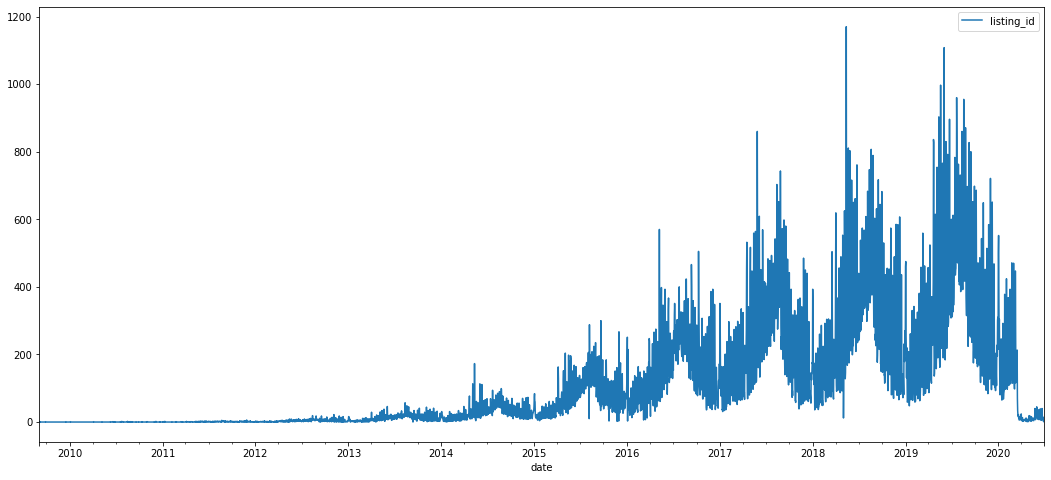

In [969]:
df.plot(figsize=(18,8));

<b> Observations </b>: The figure shows that there is a periodic change that happens every year. This change seems to be exponential as time progresses. Additionally, the figure shows the 'noisy' pattern, which may suggest that there is also some periodic changes happening from day to day. It is good to note that this noise patterns increase in intensity as time progresses.

<b>What's next?</b>: We will try to play some more with the data to understand its characteristic.

In [936]:
df = df.asfreq(freq='D',fill_value=0)
#this step is not a requirement in Prophet since it can adjust to frequency and can accept NaN values

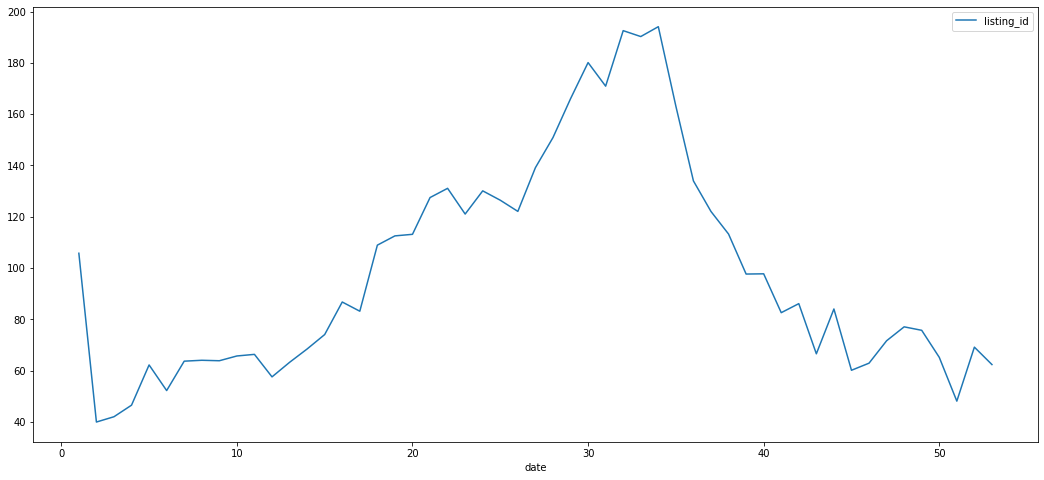

In [966]:
df.groupby(df.index.week).mean().plot(figsize=(18,8));

<b>Observation</b>: Looking over the data on a weekly basis, we can immediately see that there is a yearly seasonality. In addition, weeks 1, 21, 31 have local maxima. We have to keep this in mind for modelling.

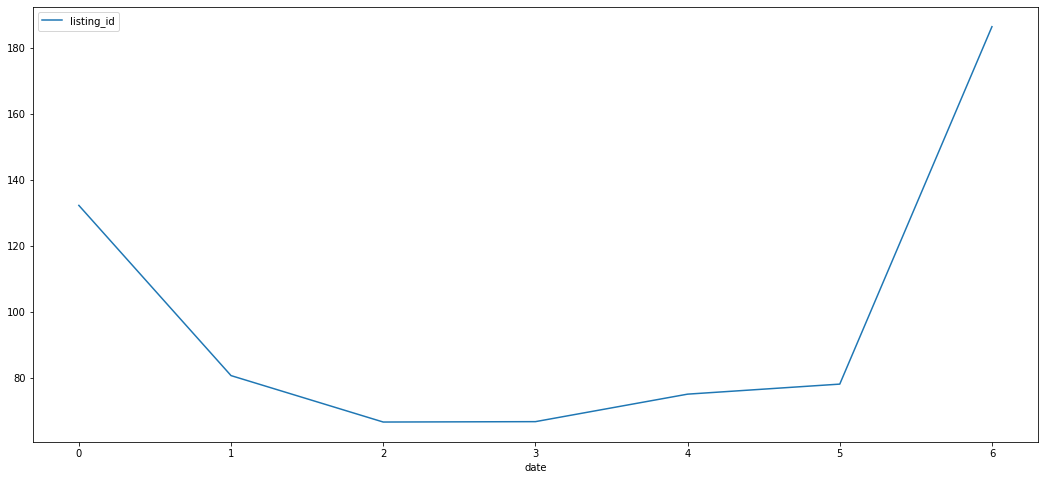

In [946]:
df.groupby(df.index.dayofweek).mean().plot(figsize=(18,8));

<b>Observations</b>: Similar to week-by-week observations, we see that monday (day 0) and sunday (day 6) are local maxima. This tells us that there is weekly seasonality in our data.

<b>What's next?</b>: We can decide to model the data as is or simplify the data by resampling to monthly or weekly basis. It may be a good start on a simplified dataset (resampling to weekly).

In [600]:
df_week = df.resample('W').sum()
#we can adjust our time frequency using resample.
#As an initial test, we want to model and forecast on a weekly basis first.

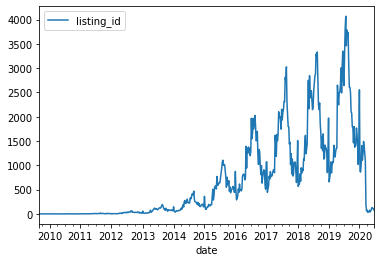

In [602]:
df_week.plot();

<b>Observation</b>: We made a separate dataframe called <b>df_week</b> that captures the behaviour on a weekly basis.

<b> What's next?</b>: We want to forecast the total Airbnb reviews in Copenhagen using Prophet. The requirement for Prophet dataframe input is that the values column should be named <b>y</b> while the temporal values column should be named as <b>ds</b>.

### Step 3: Preparing dataset for Prophet

In [970]:
df_week = df_week.rename(columns={'listing_id':'y'},inplace=False)
df_week['ds'] = df_week.index
#Here we start to rename our dataframe

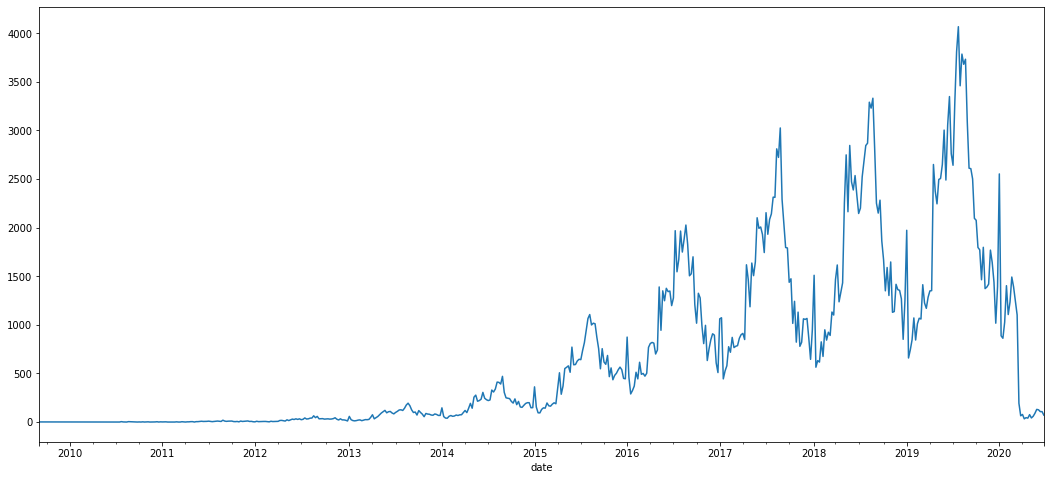

In [971]:
df_week.y.plot(figsize=(18,8));

<b>Observations</b>: By resampling to 'weekly', we have smoothened out our dataset. Therefore it's easier to model since we have eliminated the weekly seasonality of our data and focusing on yearly seasonality instead.

In [973]:
train_week = df_week['2015':'2018']
test_week = df_week['2019']

<b>Observation</b>: We split the data to train and test. This is to manually create a Prophet model by fitting to a train dataframe and test its accuracy using the test dataframe. I decided to start the training model with year-2015 to 2018, and forecast year 2019, which is about 52 points.

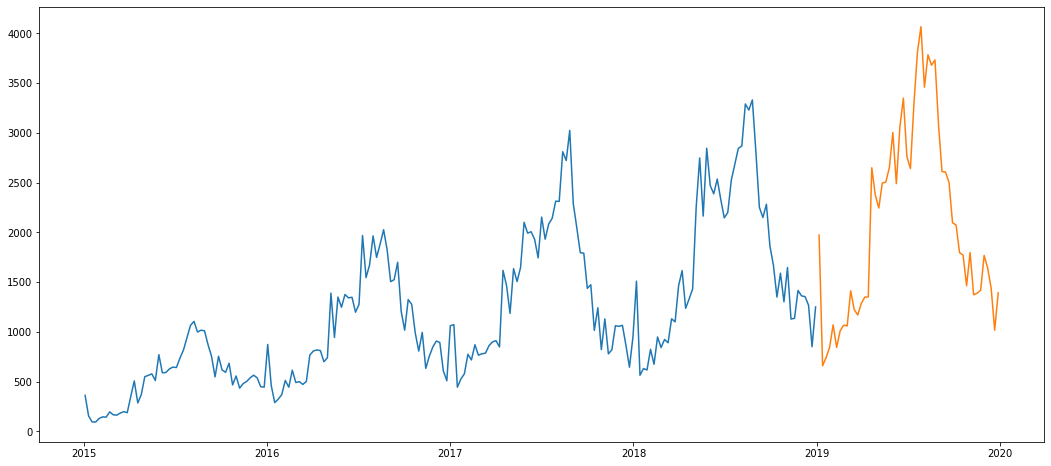

In [974]:
plt.subplots(figsize=(18,8))
plt.plot(train_week.y)
plt.plot(test_week.y);
#visualizing the train and test split of the data

<b>Observation</b>: We have now successfully made two dataframes, each with the required name for Prophet (y, ds).

<b> What's next?</b>: We are now ready to model and forecast using Prophet

### Step 4: Modelling Prophet using its default values

FBprophet algorithm was developed by Facebook group to forecast social media actions (i.e., page visits, # of clicks). It relies mainly on <b>decomposition</b> of time series data to sub-components, namely trend (g(t)), seasonality (s(t)), holidays (h(t)), and non-fitted components (e(t), residuals). These components are individually fitted and added to to model a time-series (y(t)). More on this by reading their white paper: https://peerj.com/preprints/3190.pdf

- Trend, g(t): the general parameter to tune is <b>growth = ('linear' or 'logistic')</b>, since this will ultimately define what other hyperparameters are needed to fine tune. <i>Linear growth</i> means that there will be no saturation of observed data in the future while <i>Logistic growth</i> means otherwise. The goodness of fit can be further fine tuned with <b>changepoints</b>, <b>n_changepoints</b> and <b>changepoint_prior_scale</b> but in turn, this increases the uncertainty with the forecast results. My self explanation to this is that if there is higher granularity of capturing changes (i.e., higher changepoints) during data fitting, this granularity will be extended in forecasting and its likelihood for it to happen is inferred by some variance.

- Seasonality, s(t): Prophet by default captures the data if there is periodic changes on a yearly, weekly, or daily basis, often defined as seasonality. These periodic changes are fitted with Fourier series. This can be done automatically / <b>'auto'</b> or manually adding seasonality features using <b>add_seasonality()</b> function in prophet. When done manually, there is a paremeter called <b>period</b> which can be equated to periodic changes in days (i.e., 365.25 for year, 30.5 for monthly), a parameter called <b>fourier_order</b> which identifies how many sine function should be fitted. between 3-20 is a good number and it is highly depends on how the each seasonality oscillates. More oscillations means higher order. Lastly, there is <b>seasonality_prior_scale(for auto) or prior_scale(for manual)</b>, which fine tunes the fit in exchange of uncertainty in forecasting results.

- Holidays, h(t): I believe this is where Prophet has an advantage. If, during initial assessment, specific holidays impact the observation, we can pass a dataframe, which lists the holidays impacting the data or one can add holidays via <b>add_country_holidays</b> during instantiation.

In [977]:
def model_prophet(inst,df_train,df_test,freq):
    model = prophet.fit(df_train)
    model_df = model.make_future_dataframe(periods=len(df_test),freq=freq)
    forecast = model.predict(model_df)
    
    
    model.plot(forecast, figsize=(18,4))
    model.plot_components(forecast,figsize=(18,8))
    plt.show();
    
    return model

<b>Observations</b>: The function <mark>model_prophet</mark> automatically creates a visual representation of the model and model components. This functions return the model for further analysis. It needs an instantiated Prophet, train and test dataframes, and time-frequency of the dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


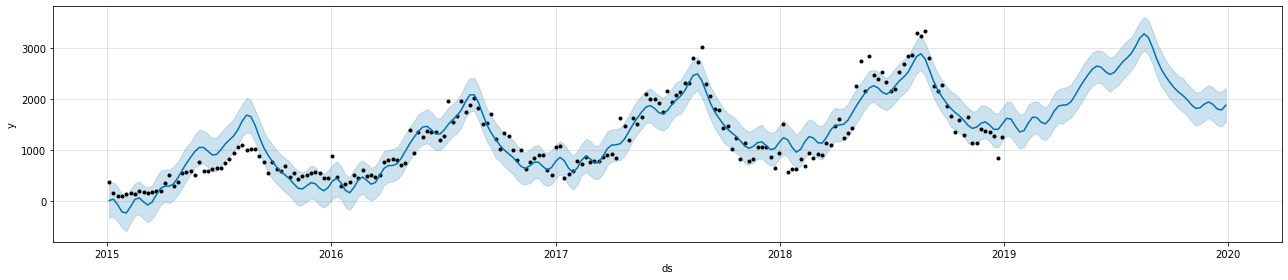

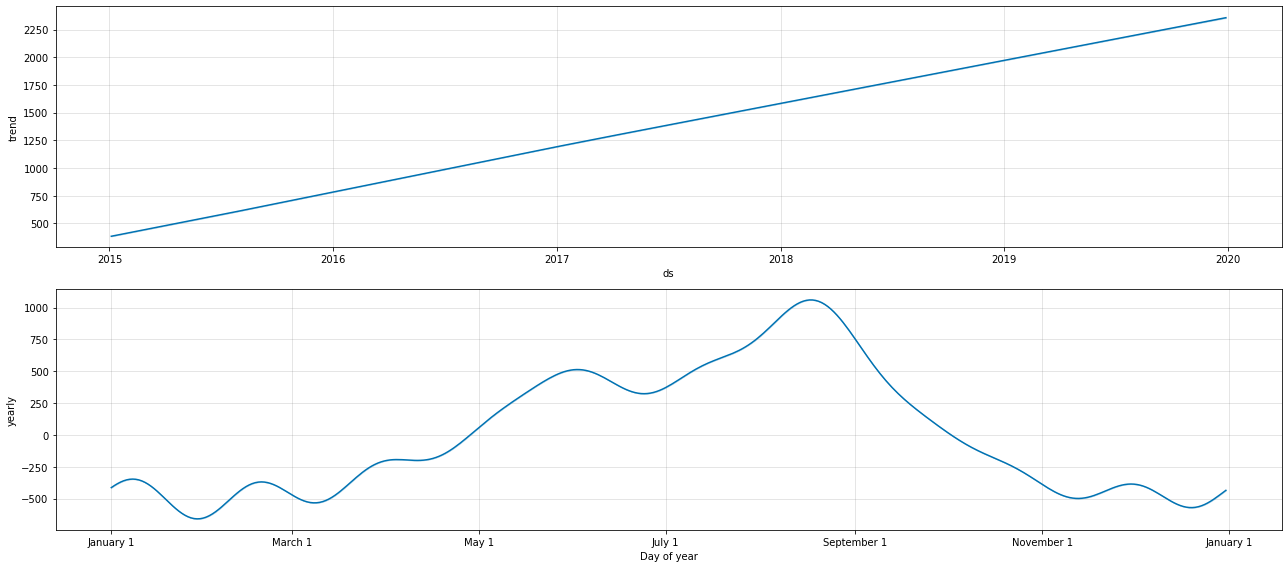

In [978]:
prophet = Prophet()

model_1 = model_prophet(inst=prophet,df_train=train_week,df_test=test_week,freq='W')

<b>Observations</b>: We used the default values of Prophet and made model_1, which shows a fairly good fit of our dataset.

<b>What's next?</b>: We try to dig deeper into the model by creating function <mark>plot_results</mark> to visually see how we fared with model and forecasting. The required input would be a prophet model as well as test and train dataset so that we can quantify how the model fairs with actual values using <i> root mean squared error (RMSE) </i>.

In [1015]:
def plot_results(model,df_train,df_test):
    """
    plotting the modelling and forecasting of Prophet
    """

    #making forecast dataframe
    prophet_model = model.predict(df_train)
    prophet_forecast = model.predict(df_test)

    #calculating root mean squared
    RMSE_model = np.sqrt(mean_squared_error(df_train.y,prophet_model.yhat))
    RMSE_forecast = np.sqrt(mean_squared_error(df_test.y,prophet_forecast.yhat))

    #plotting
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(13,8))
    
    ax1.scatter(df_train.index,df_train.y,label='train',color='navy',alpha=0.5)
    ax1.plot(prophet_model.ds,prophet_model.yhat,label='model',color='dodgerblue',alpha=0.8)
    ax1.fill_between(prophet_model.ds,prophet_model.yhat_lower,prophet_model.yhat_upper,color='lightskyblue',alpha=0.3)
    ax1.set_title('modelling - RMSE: {:.3f}'.format(RMSE_model))
    
    ax2.scatter(df_test.index,df_test.y,label='test',color='navy',alpha=0.5)
    ax2.plot(prophet_forecast.ds,prophet_forecast.yhat,label='forecast',color='dodgerblue',alpha=0.8)
    ax2.fill_between(prophet_forecast.ds,prophet_forecast.yhat_lower,prophet_forecast.yhat_upper,color='lightskyblue',alpha=0.3)
    ax2.set_title('forecasting - RMSE: {:.3f}'.format(RMSE_forecast))


    plt.show();

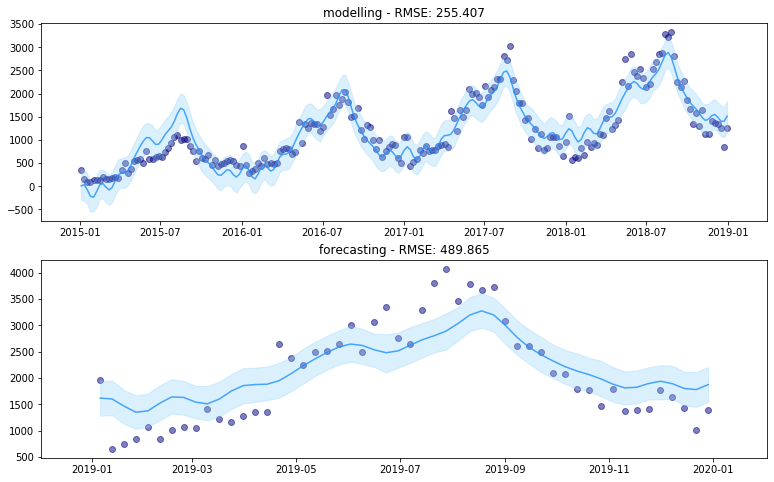

In [1016]:
plot_results(model=model_1,df_train=train_week,df_test=test_week)

<b>Observation</b>: Our model_1 somewhat captures the trend and seasonality in that the model shows trend and seasonality similar to the observed data. Looking at our forecast, a lot of observed data lies outside the forecast, suggesting that the model showed poor performance in terms of predicting the future.

<b>What's next?</b>: We see that the 'yearly' peaks are modelled and forecasted poorly by our initial model. Moving forward, I would change the seasonality to 'multiplicative' and tweak some parameters if necessary.

### Step 5: Modelling Prophet using multiplicative seasonality

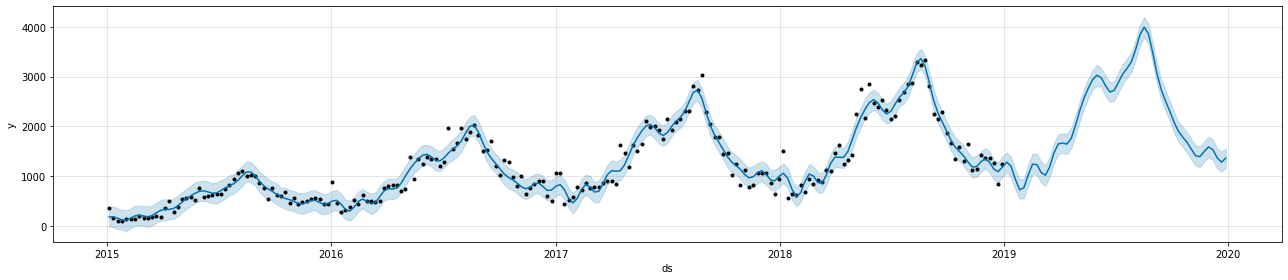

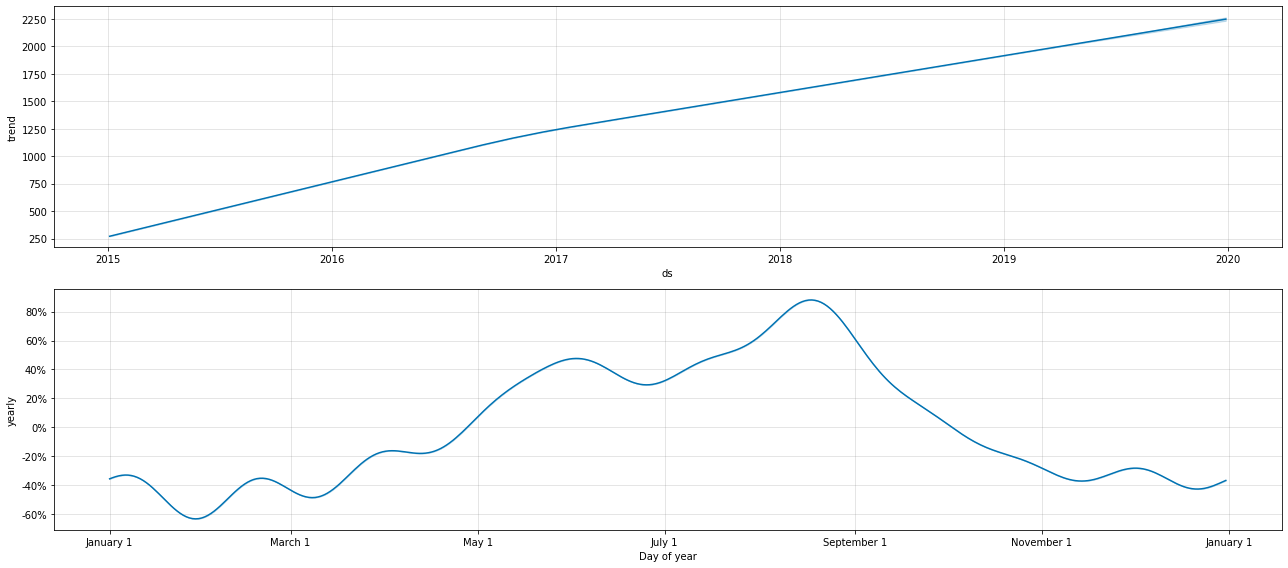

In [1020]:
prophet = Prophet(yearly_seasonality=True,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative')
model_2 = model_prophet(inst=prophet,df_train=train_week,df_test=test_week,freq='W')

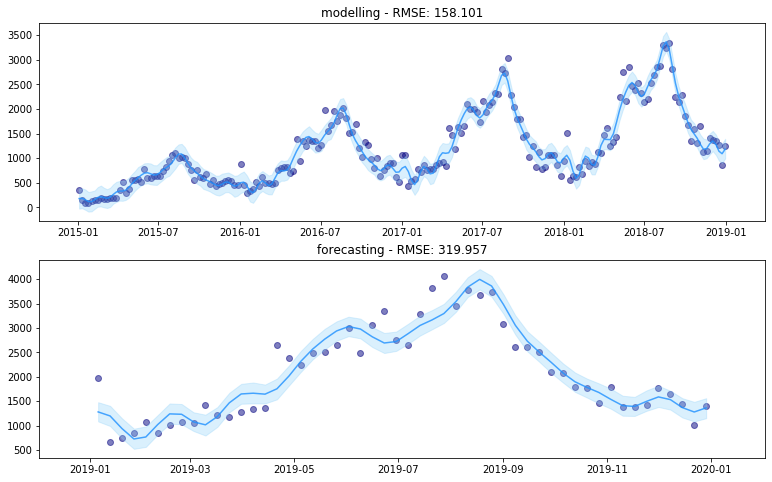

In [1021]:
plot_results(model=model_2,df_train=train_week,df_test=test_week)

<b>Observation</b>: Our model_2 can now capture the yearly peak maxima of our data. Moreover, the train data is somewhat within the confidence interval of our model. These observations are also true with the forecasts and test data. More importantly, the RMSE of model_2 is significantly lower than model_1.

<b>What's next?</b>: We are still seeing some irregularities in model, such as failure to capture the peak occuring at the beginning of each year. One of the approach is to modify the fourier_order of the yearly seasonality to capture this periodic occurence by increasing fourier order and/or prior_scale. What we can do turn-off the auto-seasonality function, manually make a seasonality, and perform a grid_search on fourier order and prio_scale parameters.

### Step 6: Performing 'grid-search' with seasonal hyperparameters - fourier_order and prior_scale

In [1036]:
#initializing input
grid_1 = np.arange(5,31,1) #choosing fourier order between 5 and 30
grid_2 = np.arange(1,21,1) #choosing prior scale between 1 and 21. 13 (one-point per month)

param1_list = []
param2_list = []
mse_list = []

best_score = float('inf')

#making grid search of param_1 and param_2
for param_1 in grid_1:
    for param_2 in grid_2:
        prophet = Prophet(yearly_seasonality=False, #turning off auto-seasonality
                          weekly_seasonality=False,
                          daily_seasonality=False,
                         ).add_seasonality(name='Yearly',
                                           period=365.25,
                                           fourier_order=param_1,
                                           prior_scale=param_2,
                                           mode='multiplicative',
                                          )
        model = prophet.fit(train_week)
        predictions = model.predict(test_week)
        
        #evaluating RMSE
        try:
            RMSE = np.sqrt(mean_squared_error(test.y,predictions.yhat))
            
            if RMSE < best_score:
                best_score = RMSE
                print('Best score: RMSE:{:.3f}, fourier:{}, scale:{}'.format(best_score,param_1,param_2))
        except:
            print('Cannot calculate MSE with N:{} and scale:{}'.format(param_1,param_2))
        
        param1_list.append(param_1)
        param2_list.append(param_2)
        mse_list.append(RMSE)

Best score: RMSE:303.273, fourier:5, scale:1
Best score: RMSE:303.229, fourier:5, scale:6
Best score: RMSE:303.131, fourier:5, scale:10
Best score: RMSE:302.963, fourier:5, scale:12
Best score: RMSE:302.816, fourier:6, scale:1
Best score: RMSE:302.723, fourier:6, scale:2
Best score: RMSE:302.718, fourier:6, scale:6
Best score: RMSE:302.686, fourier:6, scale:7
Best score: RMSE:302.536, fourier:6, scale:10
Best score: RMSE:302.305, fourier:11, scale:1
Best score: RMSE:302.057, fourier:11, scale:2
Best score: RMSE:301.901, fourier:11, scale:4
Best score: RMSE:301.300, fourier:13, scale:1
Best score: RMSE:301.276, fourier:13, scale:2
Best score: RMSE:301.135, fourier:13, scale:6
Best score: RMSE:300.829, fourier:15, scale:1
Best score: RMSE:295.769, fourier:17, scale:1
Best score: RMSE:295.688, fourier:17, scale:15
Best score: RMSE:293.474, fourier:18, scale:1
Best score: RMSE:293.411, fourier:18, scale:2
Best score: RMSE:293.407, fourier:18, scale:12
Best score: RMSE:293.361, fourier:18, 

<b>Observations</b>: We have now identified that the best MSE so far is yearly_seasonality with fourier order of 26 and prior scale of 16. We can visualize these using heatmap.

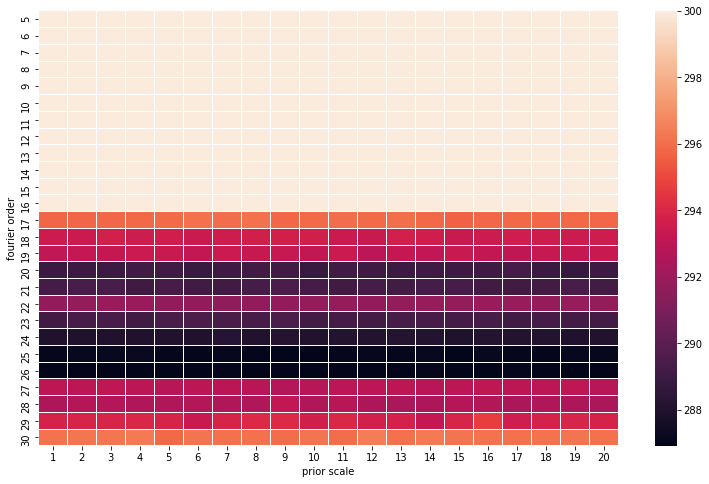

In [1068]:
import seaborn as sns

#reshaping the list
reshape_rmse = np.reshape(mse_list,(len(grid_1),len(grid_2)))

#plotting

fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(reshape_rmse,yticklabels=grid_1,xticklabels=grid_2,linecolor='white',robust=True,linewidths=0.01,vmax=300)

plt.xlabel('prior scale')
plt.ylabel('fourier order');

<b>Observation</b>: Heatmap shows that the fourier_order parameter mostly controls the RMSE values and less of the prior_scale. The lowest RMSE values are from fourier_order = 20,25,26.

<b>What's next?</b>: We are going to let the default value of prior_scale (10) and use fourier_order=26.

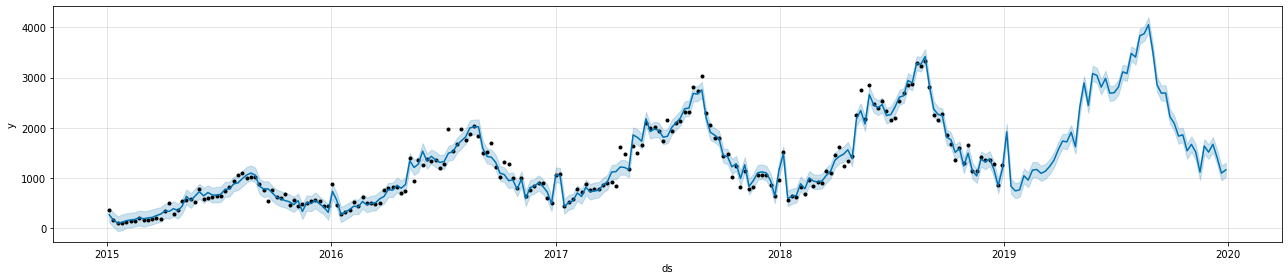

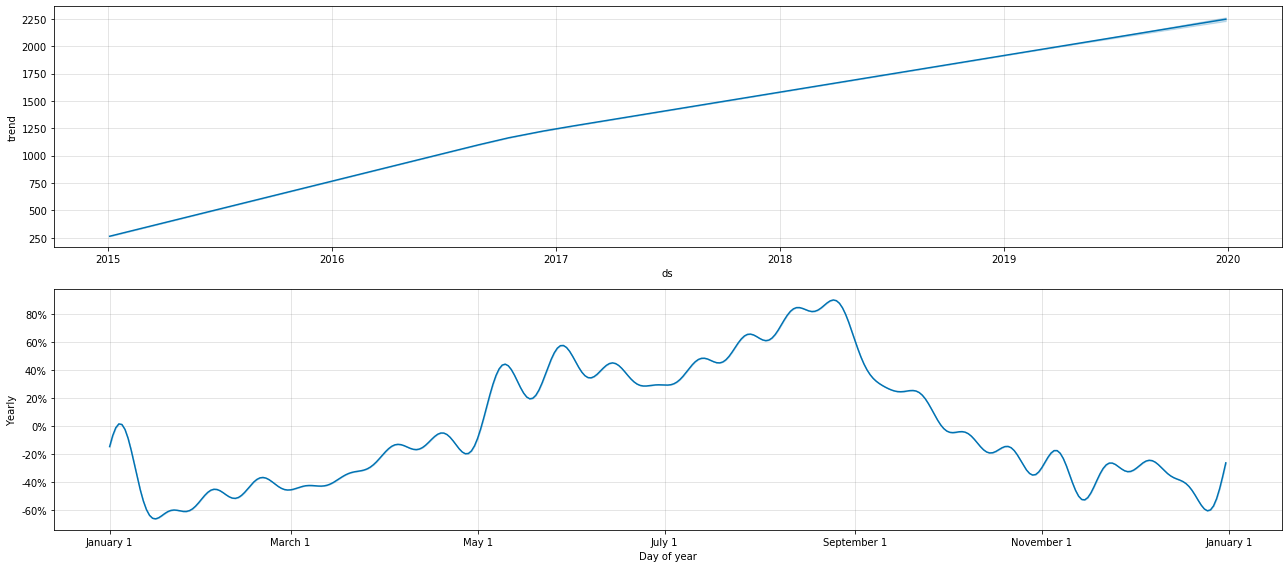

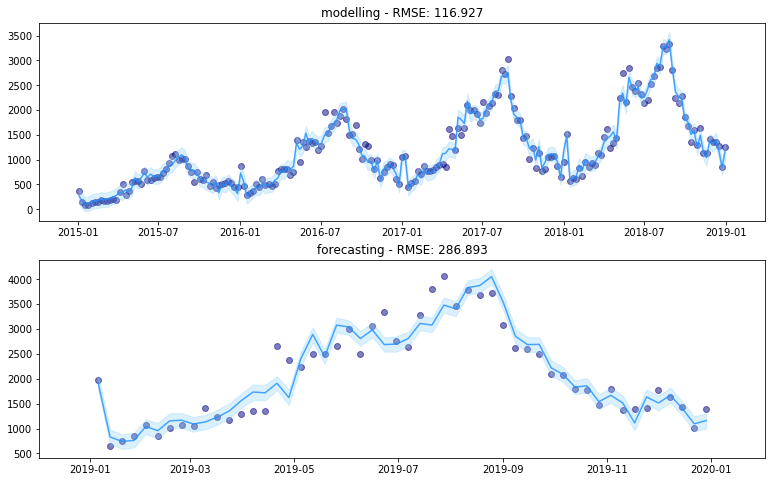

In [1073]:
prophet = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                 ).add_seasonality(name='Yearly',
                                   period=365.25,
                                   fourier_order=26,
                                   mode='multiplicative'
                                  )

model_3 = model_prophet(inst=prophet,df_train=train_week,df_test=test_week,freq='W')

plot_results(model=model_3,df_train=train_week,df_test=test_week)

<b>Observations</b>: Let's break the results down indvidually. First, we see see that the trend component look fairly similar to model_2, which makes sense because we have not touched any parameters that would change it. On the other hand, the seasonality_component has already captured the local maxima, especially in the beginning of the year. This, has significantly impacted the RMSE values between the model/forecast and data.

We also take note that fourier_order = 26, could be 'overfitting' the data. However, we have to take into account that our weekly data is a sum of daily reviews, therefore, oscillations (i.e., higher fourier order) are expected. 

<b>What's next?</b>: I will not touch the parameter for the trend component seeing that it fits fairly  suits the fitting. Therefore, I would end my modelling and forecasting for the weekly data here and proceed in analysing the daily data.

### Step 7: Modelling Prophet using daily data values

In [1077]:
df_days = df.copy()

In [1078]:
df_days = df_days.rename(columns={'listing_id':'y'},inplace=False)
df_days['ds'] = df_days.index

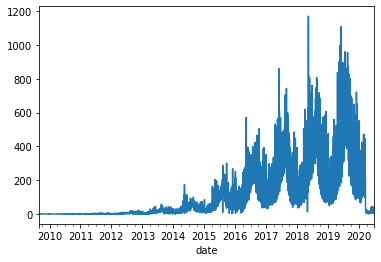

In [1079]:
df_days.y.plot()

In [1080]:
train_days = df_days['2015':'2018']
test_days = df_days['2019']

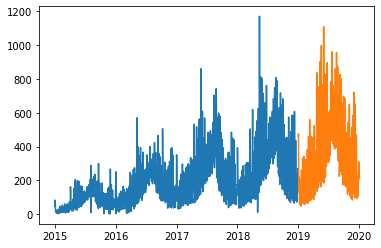

In [1081]:
plt.plot(train_days.y)
plt.plot(test_days.y);

<b>Observation</b>: Our df_days are now successfully splitted to train_days and test_days dataframe. Similar to weekly dataset, it is also imperative to change the column names to y(values) and ds(date).

<b>What's next?</b>: We will use values as model_3, and look at the results.

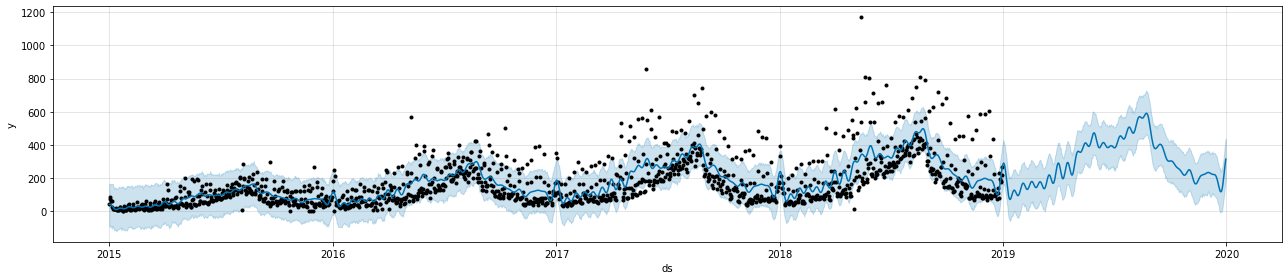

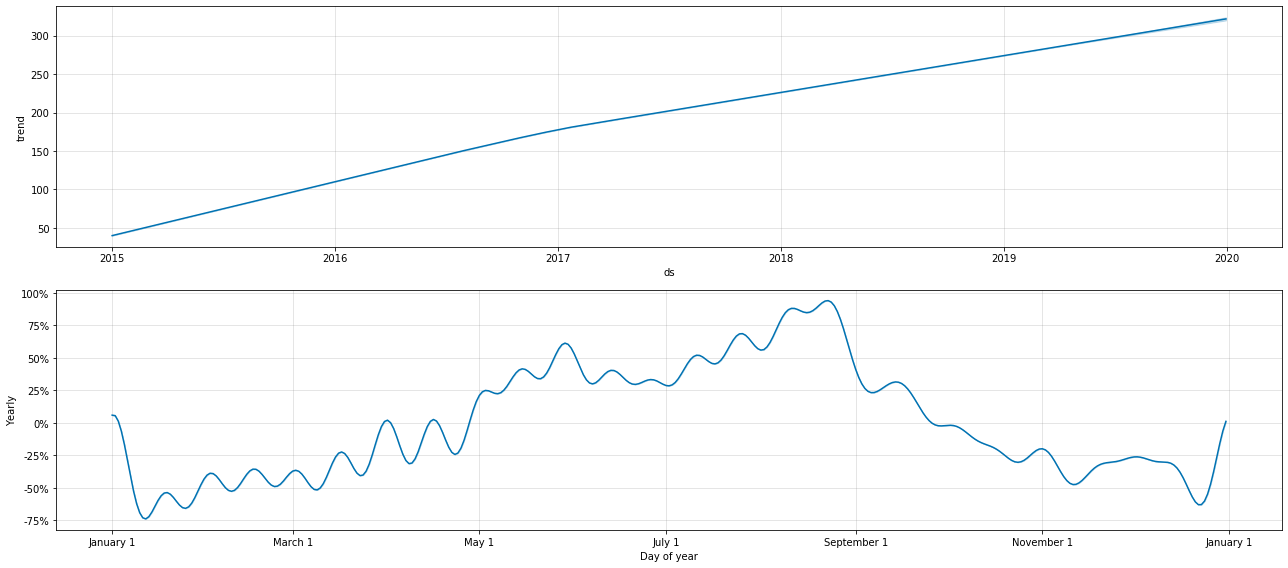

In [1084]:
prophet = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                 ).add_seasonality(name='Yearly',
                                   period=365.25,
                                   fourier_order=26,
                                   mode='multiplicative'
                                  )

model_4 = model_prophet(inst=prophet,df_train=train_days,df_test=test_days,freq='D')

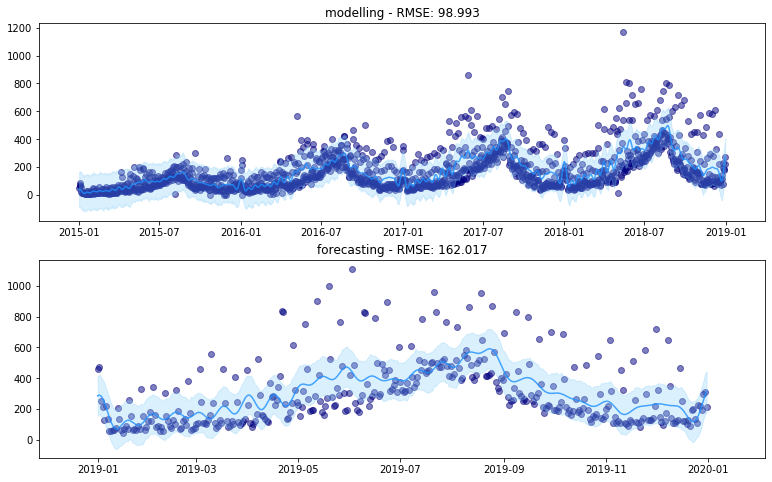

In [1085]:
plot_results(model=model_4,df_train=train_days,df_test=test_days)

<b>Observation</b>: Obviously, we were able to capture the yearly component, but the there are some data points that are out of bounds with our confidence interval. We can make a better model.

<b>What's next?</b>: Since we know already that there is a weekly seasonality with a multiplicative effect, we proceed with fine tuning that part. I will also decrease the fourier_order of 'yearly seasonality' to 20.

### Step 8: Adding weekly_seasonality and performing 'grid_search'

In [1090]:
#initializing input
d_grid_1 = np.arange(5,31,1) #choosing fourier order between 5 and 30
d_grid_2 = np.arange(1,21,1) #choosing prior scale between 1 and 21. 13 (one-point per month)

d_param1_list = []
d_param2_list = []
d_mse_list = []

best_score = float('inf')

#making grid search of param_1 and param_2
for param_1 in d_grid_1:
    for param_2 in d_grid_2:
        prophet = Prophet(yearly_seasonality=False, #turning off auto-seasonality
                          weekly_seasonality=False,
                          daily_seasonality=False,
                         ).add_seasonality(name='Yearly',
                                           period=365.25,
                                           fourier_order=20,
                                           mode='multiplicative',
                                          ).add_seasonality(name='Weekly',
                                                            period=7,
                                                            fourier_order=param_1,
                                                            prior_scale=param_2,
                                                            mode='multiplicative',
                                                           )
        model = prophet.fit(train_days)
        predictions = model.predict(test_days)
        
        #evaluating RMSE
        try:
            RMSE = np.sqrt(mean_squared_error(test_days.y,predictions.yhat))
            
            if RMSE < best_score:
                best_score = RMSE
                print('Best score: RMSE:{:.3f}, fourier:{}, scale:{}'.format(best_score,param_1,param_2))
        except:
            print('Cannot calculate MSE with N:{} and scale:{}'.format(param_1,param_2))
        
        d_param1_list.append(param_1)
        d_param2_list.append(param_2)
        d_mse_list.append(RMSE)

Best score: RMSE:87.444, fourier:5, scale:1
Best score: RMSE:87.438, fourier:5, scale:2
Best score: RMSE:87.438, fourier:5, scale:4
Best score: RMSE:87.432, fourier:5, scale:7
Best score: RMSE:87.431, fourier:5, scale:8
Best score: RMSE:87.430, fourier:5, scale:15
Best score: RMSE:87.428, fourier:6, scale:7
Best score: RMSE:87.427, fourier:6, scale:15
Best score: RMSE:87.425, fourier:9, scale:11
Best score: RMSE:87.422, fourier:10, scale:13
Best score: RMSE:87.419, fourier:20, scale:7


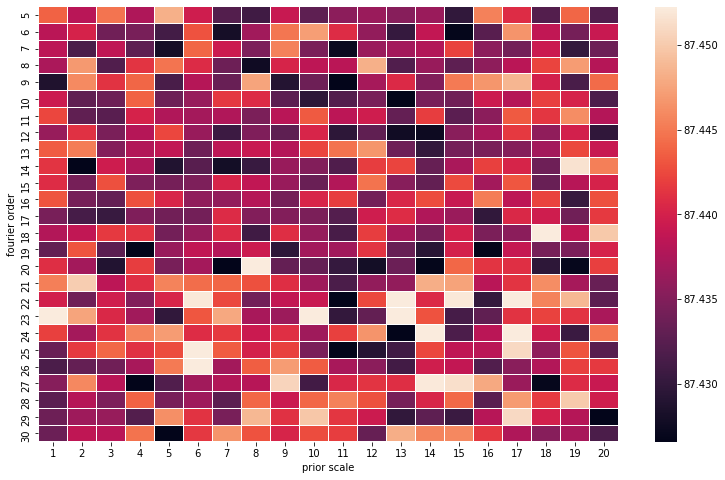

In [1092]:
#mapping the grid

#reshaping the list
reshape_rmse = np.reshape(d_mse_list,(len(d_grid_1),len(d_grid_2)))

#plotting

fig, ax = plt.subplots(figsize=(13,8))
sns.heatmap(reshape_rmse,yticklabels=grid_1,xticklabels=grid_2,linecolor='white',robust=True,linewidths=0.01)

plt.xlabel('prior scale')
plt.ylabel('fourier order');

<b>Observation</b>: Looking at the mapped RMSE as a function of fourier_order and prior_scale, we see that there is no definite trend. More importantly, the changes in RMSE values in all tested values are only marginal. This suggests that these parameters do not significantly change the fit and forecast.

<b>What's next?</b>: I will let let the fourier_order=5 (lowest tested value) and prior_scale = 15. I chose the lowest fourier_order since our initial observation for weekly fluctuation do not oscillate that much. Additionally, I chose a prior_scale of 15 to allow more flexibilit in fitting.

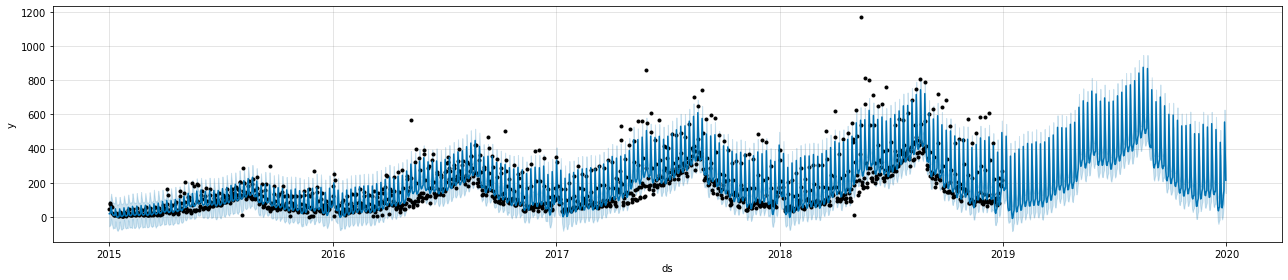

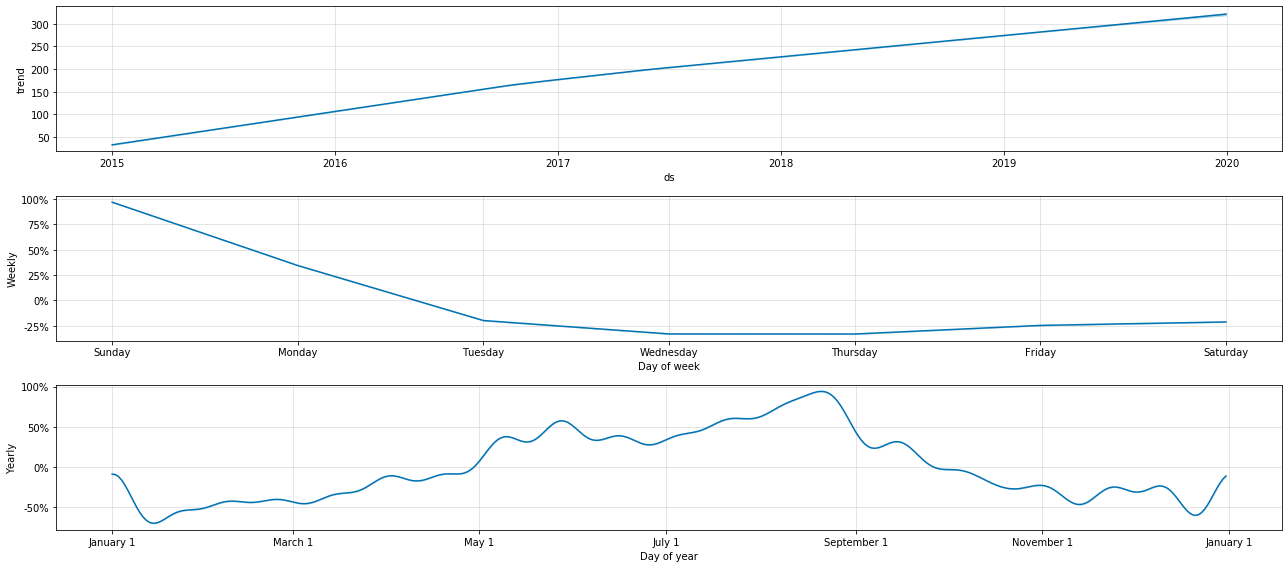

In [1147]:
prophet = Prophet(yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                 ).add_seasonality(name='Yearly',
                                   period=365.25,
                                   fourier_order=20,
                                   mode='multiplicative'
                                  ).add_seasonality(name='Weekly',
                                                    period=7,
                                                    fourier_order=5,
                                                    prior_scale=15,
                                                    mode='multiplicative'
                                                   )

model_5 = model_prophet(inst=prophet,df_train=train_days,df_test=test_days,freq='D')

<b>Observations</b>: Our model somewhat agrees with our data in that we are able to capture weekly maxima in our dataset. In addition, our weekly and yearly seasonality trend also agrees with our previous inital data analysis.

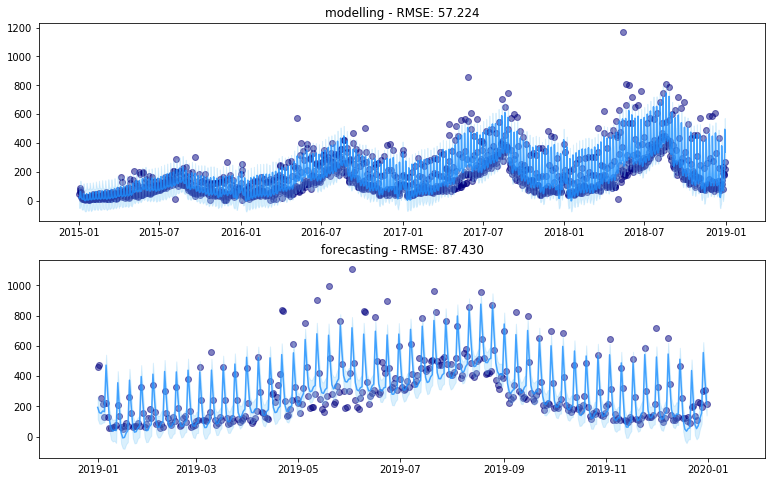

In [1148]:
plot_results(model=model_5,df_train=train_days,df_test=test_days)

<b>Observation</b>: Our quick, fine-tuning of Prophet led to a steep reduction of RMSE values of model and forecast, relative to the data. Looking at the forecast, the fit is not perfect. For example, the month of May and June looks poorly fitted. One thing to do is to flag these dates and add it as a regressor using .add_regressor component. However, I will not go over with it at the moment.

#### Conclusion:

We used the Airbnb listing to perform time-series forecasting in Prophet. The general objective of this exercise was to predict our data one-year ahead. Using Prophet we have successfully and rapidly implemented the model. We started from the default Prophet values and fine-tuned the parameters, with the focus on seasonality. Overall, the favourable outcome with low RMSE values stems from the fact that Prophet fits the data from a decomposition standpoint (i.e., fitting trend, seasonality, holidays etc.) and that our data itself has a clear trend and seasonality. 